In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
# url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR30F8lYP3jG7YOq8es0PBpJIE5yvRVZffOyaqC0GgMBN6yt0Q-NI8pxS7hd1F9dYXnowSC6zpZmW9D/pubhtml'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
# soup =BeautifulSoup(content, 'lxml')

In [5]:
# data = soup.findAll(text=re.compile("Last update: .+"))
# data

In [6]:
# m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
# data_date_time = ' '.join([m.group(1), m.group(2)])
# data_date_time = re.sub("[\.]","",data_date_time)
# data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
# data_date_time
data_date_time = datetime.now().strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-03-20 21:09'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,1,Currently being updated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,CASES,DEATHS,RECOVERED,RECOVERED,UNRESOLVED,UNRESOLVED,UNRESOLVED,NaN,NaN,NaN,NaN,NaN,NaN
3,4,271537,11380,89672,89672,170485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,177,Nepal,1,0,0,0,0.00%,NaN,1,Source,NaN,NaN,1,0
177,178,Vatican City,1,0,0,0,0.00%,NaN,NaN,Source,NaN,NaN,1,0
178,179,Queue,3530,400,153,0,NaN,NaN,NaN,NaN,NaN,NaN,3130,153
179,180,TOTAL,271537,24692,11380,1210,4.19%,7987,89672,NaN,NaN,NaN,246735,10179


### International

In [9]:
df_intl=dfs[0]
df_intl  = df_intl.drop(df_intl .columns[0], axis=1)
df_intl  = df_intl.drop(list(range(6)), axis=0)
num_cols = len(df_intl.columns)
columns = ['d'] * num_cols
columns[0]='international'
columns[1]='cases'
df_intl.columns=columns
df_intl



,international,cases,d,d,d,d,d,d,d,d,d,d,d
6,China,80967,39,3248,3,4.01%,2314,70420,Source,NaN,NaN,80928,3245
7,Italy,47021,5986,4032,627,8.57%,2655,5129,Source,NaN,NaN,41035,3405
8,Spain,20410,2333,1044,211,5.12%,1141,1588,Source,NaN,NaN,18077,833
9,Iran,19644,1237,1433,149,7.29%,NaN,6745,Source,NaN,NaN,18407,1284
10,Germany,19848,4528,60,16,0.30%,2,115,Source,NaN,NaN,15320,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Nepal,1,0,0,0,0.00%,NaN,1,Source,NaN,NaN,1,0
177,Vatican City,1,0,0,0,0.00%,NaN,NaN,Source,NaN,NaN,1,0
178,Queue,3530,400,153,0,NaN,NaN,NaN,NaN,NaN,NaN,3130,153
179,TOTAL,271537,24692,11380,1210,4.19%,7987,89672,NaN,NaN,NaN,246735,10179


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)
df_intl = df_intl.dropna(0, how='all')

#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases.drop(columns = ['China', 'Queue', 'TOTAL'], inplace=True)
df_intl_cases


international,Italy,Spain,Iran,Germany,United States,France,South Korea,Switzerland,United Kingdom,Netherlands,...,Antigua and Barbuda,Sudan,Montserrat,Gambia,Eswatini,Somalia,Central African Republic,Nepal,Vatican City,NaN
cases,47021,20410,19644,19848,17842,12612,8652,4164,3983,2994,...,1,1,1,1,1,1,1,1,1,Cases


In [12]:
na_columns = df_intl_cases.columns[df_intl_cases.columns.isna()]
df_intl_cases.drop(columns=na_columns, inplace=True)

In [13]:
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [14]:
df_intl_cases

international,Italy,Spain,Iran,Germany,United States,France,South Korea,Switzerland,United Kingdom,Netherlands,...,Djibouti,Antigua and Barbuda,Sudan,Montserrat,Gambia,Eswatini,Somalia,Central African Republic,Nepal,Vatican City
cases,47021,20410,19644,19848,17842,12612,8652,4164,3983,2994,...,1,1,1,1,1,1,1,1,1,1


In [15]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,Italy,Spain,Iran,Germany,United States,France,South Korea,Switzerland,United Kingdom,...,Djibouti,Antigua and Barbuda,Sudan,Montserrat,Gambia,Eswatini,Somalia,Central African Republic,Nepal,Vatican City
cases,2020-03-20 21:09,47021,20410,19644,19848,17842,12612,8652,4164,3983,...,1,1,1,1,1,1,1,1,1,1


In [16]:
# some assertion to ensure data quality
assert int(df_intl_cases['South Korea'])>6000

#### Save to file

In [17]:
from pathlib import Path
csv_file = '../data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)



In [18]:
# unnamed_cols = old_df.columns[old_df.columns.str.startswith('Unnamed')]
# old_df.drop(columns=unnamed_cols, inplace=True)

In [19]:
df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [20]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Vatican City,Venezuela,Vietnam,WORLD,Zambia
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,0,0,0,0,0,0,15,0,...,0,2,12,0,0,0,0,12,0,0
2020-02-06 08:19,0,0,0,0,0,0,0,0,15,0,...,0,3,12,0,0,0,0,12,0,0
2020-02-06 09:01,0,0,0,0,0,0,0,0,15,0,...,0,3,12,0,0,0,0,12,0,0
2020-02-06 09:46,0,0,0,0,0,0,0,0,15,0,...,0,3,12,0,0,0,0,12,0,0
2020-02-06 17:56,0,0,0,0,0,0,0,0,15,0,...,0,3,12,0,0,0,0,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20 17:08,22,64,82,74,1,128,136,5,800,2203,...,140,3269,15777,94,33,1,42,87,0,2
2020-03-20 18:08,22,64,82,74,1,128,136,5,800,2203,...,140,3983,15777,94,33,1,42,87,0,2
2020-03-20 19:10,22,64,82,74,1,128,136,5,800,2203,...,140,3983,17474,94,33,1,42,87,0,2


In [21]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-03-20 21:09')

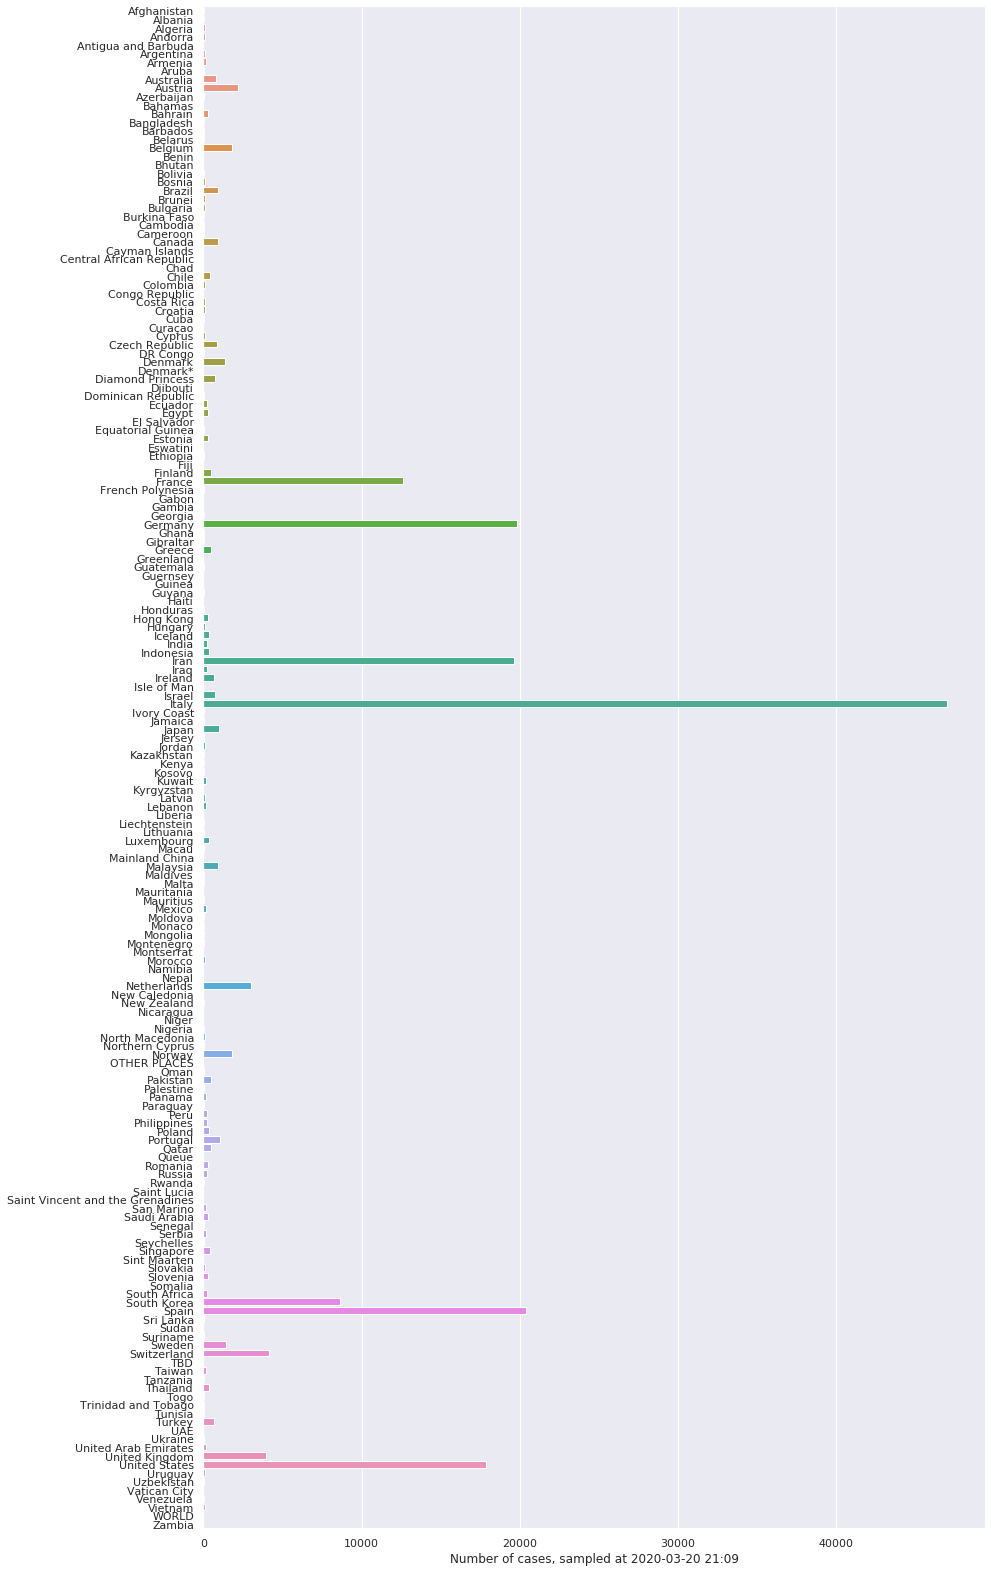

In [22]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,28)})
ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)



In [23]:
png_file='../images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)